In [9]:
!pip install -U datasets

In [1]:
import torch
import torch.nn.functional as F

from datasets import load_dataset

/user/HS402/hk01159/NLP-project/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [12]:
labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)}
itol = {i: l for l, i in ltoi.items()}

In [13]:
from transformers import AutoTokenizer

model_checkpoint = "microsoft/deberta-v3-base" # Or deberta-v3-large, etc.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Check if the tokenizer is a fast tokenizer (it should be for DeBERTa-v3)
assert tokenizer.is_fast, "Only fast tokenizers are supported for this example."

In [14]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True, # Crucial for pre-tokenized input
        max_length=512,
        padding="max_length"

    )

    labels = []
    for i, label_sequence in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None: # Special tokens ([CLS], [SEP])
                label_ids.append(-100)
            elif word_idx != previous_word_idx: # First token of a new word
                label_ids.append(ltoi[label_sequence[word_idx]])
            else: # Subsequent tokens of the same word
                label_ids.append(-100)


            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [15]:
t = tokenizer(["Pakistan got nuked lmao"])
print(t.input_ids)
print(t.word_ids(0))

[[1, 4146, 519, 58917, 407, 107679, 2]]
[None, 0, 1, 2, 2, 3, None]


In [17]:
data = dataset.map(tokenize_and_align_labels, batched = True)

Map: 100%|█████████████████████████| 2000/2000 [00:00<00:00, 3527.58 examples/s]


In [18]:
train_data, train_labels, train_attention_mask = data['train']['input_ids'], data['train']['labels'], data['train']['attention_mask']
val_data, val_labels, val_attention_mask = data['validation']['input_ids'], data['validation']['labels'], data['validation']['attention_mask']
test_data, test_labels, test_attention_mask = data['test']['input_ids'], data['test']['labels'], data['test']['attention_mask']

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

def get_batch(split = "train"):
  data = train_data if split == "train" else val_data
  labels = train_labels if split == "train" else val_labels
  attention_mask = train_attention_mask if split == "train" else val_attention_mask
  ix = torch.randint(len(data), (batch_size,))
  x = torch.stack([torch.tensor(data[i]).long() for i in ix])
  y = torch.stack([torch.tensor(labels[i]).long() for i in ix])
  a = torch.stack([torch.tensor(attention_mask[i]) for i in ix])
  return x.to(device), y.to(device), a.to(device)


@torch.no_grad()
def estimate_loss(eval_steps):
  out = {}
  model.eval()
  for split in ["train", "validation"]:
    losses = torch.zeros(eval_steps)
    for k in range(eval_steps):
      x, y, a = get_batch(split)
      logits = model(x, attention_mask = a).logits
      loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

In [12]:
torch.set_float32_matmul_precision("high")

In [13]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
model = torch.compile(model)

In [15]:
from tqdm import tqdm

optim = torch.optim.AdamW(model.parameters(), lr=3e-5)
max_steps = 1000


for step in tqdm(range(max_steps)):
  x, y, a = get_batch("train")
  optim.zero_grad()
  with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
    logits = model(x, attention_mask = a).logits
    loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
  loss.backward()
  optim.step()
  if step % 100 == 0:
    losses = estimate_loss(100)
    print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['validation']:.4f}")


  0%|                                       | 1/1000 [00:42<11:48:28, 42.55s/it]

step 0: train loss 1.4735, val loss 1.4653


 10%|███▊                                  | 101/1000 [01:32<1:04:09,  4.28s/it]

step 100: train loss 0.1957, val loss 0.2787


 20%|████████                                | 201/1000 [02:05<57:42,  4.33s/it]

step 200: train loss 0.1609, val loss 0.2349


 30%|████████████                            | 301/1000 [02:39<50:43,  4.35s/it]

step 300: train loss 0.1447, val loss 0.2437


 40%|████████████████                        | 401/1000 [03:14<43:41,  4.38s/it]

step 400: train loss 0.1303, val loss 0.2189


 50%|████████████████████                    | 501/1000 [03:48<36:20,  4.37s/it]

step 500: train loss 0.1273, val loss 0.2404


 60%|████████████████████████                | 601/1000 [04:22<29:06,  4.38s/it]

step 600: train loss 0.1214, val loss 0.2800


 70%|████████████████████████████            | 701/1000 [04:56<21:48,  4.38s/it]

step 700: train loss 0.1035, val loss 0.2486


 80%|████████████████████████████████        | 801/1000 [05:30<14:32,  4.38s/it]

step 800: train loss 0.1003, val loss 0.2494


 90%|████████████████████████████████████    | 901/1000 [06:05<07:14,  4.38s/it]

step 900: train loss 0.0759, val loss 0.2577


100%|███████████████████████████████████████| 1000/1000 [06:25<00:00,  2.59it/s]


In [16]:
from seqeval.metrics import f1_score, recall_score, precision_score, classification_report

In [17]:
@torch.no_grad()
def evaluate_model(split="test"):
    """Evaluate model performance on given split with seqeval metrics"""
    model.eval()
    
    if split == "test":
        data_input_ids = test_data
        data_labels = test_labels
        data_attention_mask = test_attention_mask
    elif split == "validation":
        data_input_ids = val_data
        data_labels = val_labels
        data_attention_mask = val_attention_mask
    else:
        data_input_ids = train_data
        data_labels = train_labels
        data_attention_mask = train_attention_mask
    
    # Process in smaller batches to avoid OOM
    batch_size_eval = 16
    all_true_labels = []
    all_pred_labels = []
    
    # Process the entire dataset
    for i in tqdm(range(0, len(data_input_ids), batch_size_eval), desc=f"Evaluating on {split}"):
        # Get batch
        batch_input_ids = torch.tensor(data_input_ids[i:i+batch_size_eval]).to(device)
        batch_labels = torch.tensor(data_labels[i:i+batch_size_eval]).to(device)
        batch_attention_mask = torch.tensor(data_attention_mask[i:i+batch_size_eval]).to(device)
        
        # Get predictions
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        # Convert predictions and labels to lists for seqeval
        for j in range(len(batch_input_ids)):
            true_label_ids = batch_labels[j].cpu().numpy()
            pred_label_ids = predictions[j].cpu().numpy()
            
            # Convert IDs to labels, handling special tokens
            true_seq = []
            pred_seq = []
            
            for true_id, pred_id, mask in zip(true_label_ids, pred_label_ids, batch_attention_mask[j]):
                if mask == 1 and true_id != -100:  # Only evaluate on non-padding and non-special tokens
                    true_seq.append(itol[true_id.item()])
                    pred_seq.append(itol[pred_id.item()])
            
            if true_seq:  # Only add if not empty
                all_true_labels.append(true_seq)
                all_pred_labels.append(pred_seq)
    
    # Calculate metrics using seqeval
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    report = classification_report(all_true_labels, all_pred_labels)
    
    print(f"\n=== Evaluation on {split} split ===")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nDetailed Classification Report:")
    print(report)
    
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "report": report
    }

In [40]:
out = evaluate_model()

Evaluating on test: 100%|██████████| 16/16 [00:03<00:00,  4.80it/s]



=== Evaluation on test split ===
F1 Score: 0.8737
Precision: 0.8259
Recall: 0.9273

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.86      0.94      0.90       797
          LF       0.77      0.90      0.83       482

   micro avg       0.83      0.93      0.87      1279
   macro avg       0.82      0.92      0.87      1279
weighted avg       0.83      0.93      0.87      1279



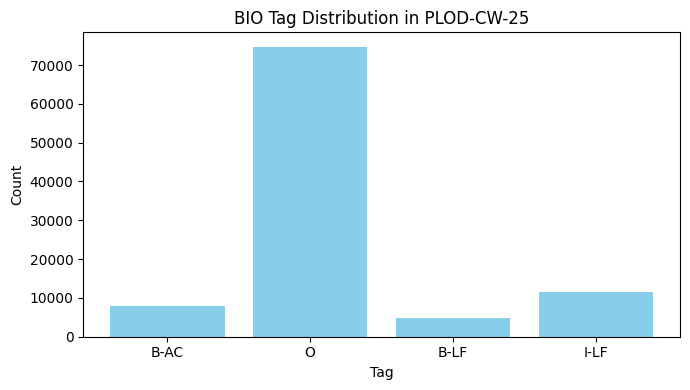

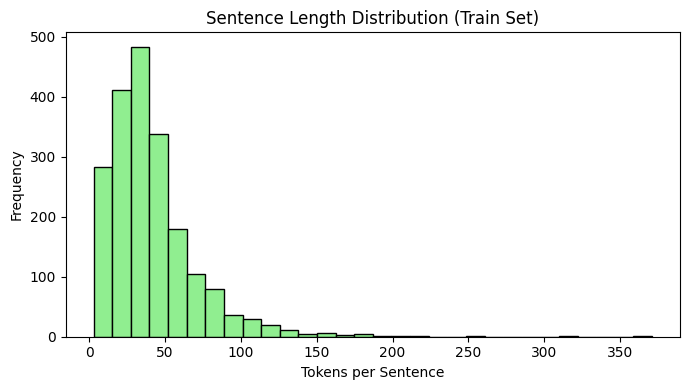

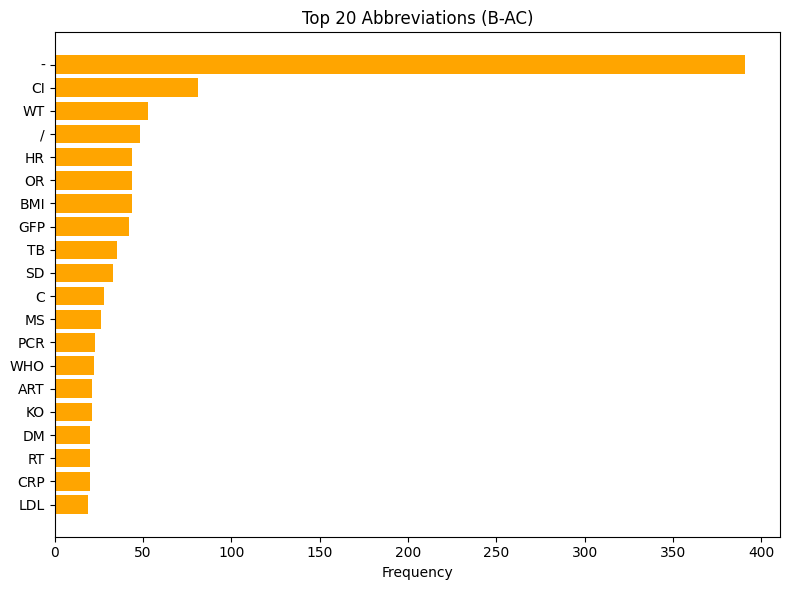

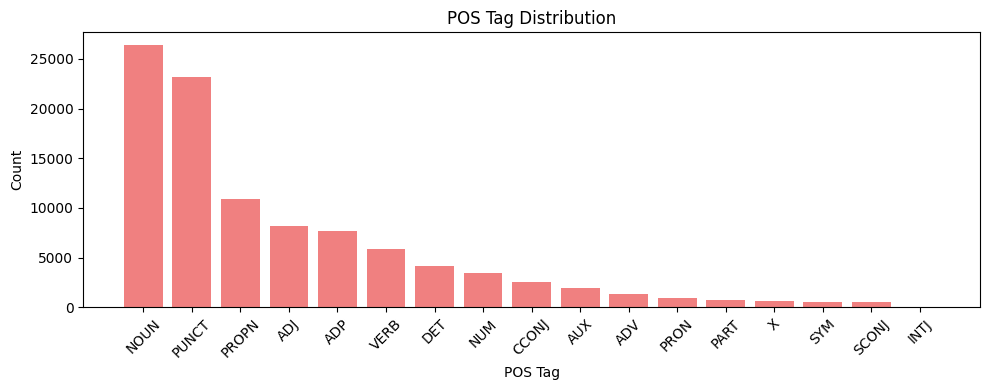

In [12]:
#visualising data
#import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Flattening lists for everything
flat_tokens = []
flat_tags = []
flat_pos = []

# Tokens
for split in dataset:
    for i in dataset[split]["tokens"]:
        flat_tokens.extend(i)

# ner tags
for split in dataset:
    for i in dataset[split]["ner_tags"]:
        flat_tags.extend(i)

# Pos tags
for split in dataset:
    for i in dataset[split]["pos_tags"]:
        flat_pos.extend(i)

#tags already strings
flat_tag_labels = flat_tags
flat_pos_labels = flat_pos

#bio tag distribution 
tag_counts = Counter(flat_tag_labels)
tag_df = pd.DataFrame(tag_counts.items(), columns=["Tag", "Count"])

plt.figure(figsize=(7, 4))
plt.bar(tag_df["Tag"], tag_df["Count"], color="skyblue")
plt.title("BIO Tag Distribution in PLOD-CW-25")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Sentence Length Distribution (Train split only)
train_lengths = [len(sentence) for sentence in dataset["train"]["tokens"]]

plt.figure(figsize=(7, 4))
plt.hist(train_lengths, bins=30, color="lightgreen", edgecolor="black")
plt.title("Sentence Length Distribution (Train Set)")
plt.xlabel("Tokens per Sentence")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#most freq abbrev
b_ac_tokens = [tok for tok, label in zip(flat_tokens, flat_tag_labels) if label == "B-AC"]
top_abbrevs = Counter(b_ac_tokens).most_common(20)

#bar plot
abbrev_df = pd.DataFrame(top_abbrevs, columns=["Abbreviation", "Frequency"])
plt.figure(figsize=(8, 6))
plt.barh(abbrev_df["Abbreviation"], abbrev_df["Frequency"], color="orange")
plt.title("Top 20 Abbreviations (B-AC)")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# pos tag distribution
pos_counts = Counter(flat_pos_labels)
pos_df = pd.DataFrame(pos_counts.items(), columns=["POS", "Count"])
pos_df = pos_df.sort_values("Count", ascending=False)

plt.figure(figsize=(10, 4))
plt.bar(pos_df["POS"], pos_df["Count"], color="lightcoral")
plt.title("POS Tag Distribution")
plt.xlabel("POS Tag")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
